![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

In [43]:
# Read data
data = pd.read_csv('rental_info.csv')
print(data.isna().sum())
print(data.shape)
data.head()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64
(15861, 15)


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [44]:
# Data preprocessing
data[['rental_date', 'return_date']] = data[['rental_date', 'return_date']].apply(pd.to_datetime)
data['rental_length_days'] = (data['return_date'] - data['rental_date']).dt.days
data['deleted_scenes'] = np.where(data['special_features'].str.contains('Deleted Scenes', na = False), 1, 0)
data['behind_the_scenes'] = np.where(data['special_features'].str.contains('Behind the Scenes', na = False), 1, 0)
data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [45]:
# Split train/test
X = data.drop(['rental_date', 'return_date', 'rental_length_days', 'special_features'], axis = 1)
y = data['rental_length_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

In [46]:
# Model fitting before model selection
rf_model1 = RandomForestRegressor(n_estimators = 100, random_state = 9)
rf_model1.fit(X_train, y_train)
y_pred1 = rf_model1.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)
print("MSE (default):", mse1)

MSE (default): 2.030141907417274


In [47]:
# Find best alpha
lasso_cv = LassoCV(cv=5).fit(X_train, y_train)
print("Best alpha：", lasso_cv.alpha_)

# Use best alpha for Lasso
lasso_best = Lasso(alpha=lasso_cv.alpha_)
lasso_best.fit(X_train, y_train)
print("Lasso coef：", lasso_best.coef_)

# Find important features
important_features_idx = np.where(lasso_best.coef_ != 0)[0]
print("Important features' index：", important_features_idx)
important_features = X.columns[important_features_idx]
print("Important features：", important_features)

Best alpha： 0.051314926953847574
Lasso coef： [ 1.28690743e+00  0.00000000e+00 -5.26570594e-01  4.87651269e-04
 -2.65188925e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.46057251e-02  2.22250766e-06 -1.01135056e-01
 -0.00000000e+00  0.00000000e+00]
Important features' index： [ 0  2  3  4  9 10 11]
Important features： Index(['amount', 'rental_rate', 'length', 'replacement_cost', 'amount_2',
       'length_2', 'rental_rate_2'],
      dtype='object')


In [48]:
# Model fitting after feature selection
X_train_selected = X_train.iloc[:,important_features_idx]
X_test_selected = X_test.iloc[:,important_features_idx]
rf_model2 = RandomForestRegressor(n_estimators = 100, random_state = 9)
rf_model2.fit(X_train_selected, y_train)
y_pred2 = rf_model2.predict(X_test_selected)
mse2 = mean_squared_error(y_test, y_pred2)
print("MSE with feature selection:", mse2)

MSE with feature selection: 2.1087287089285507


In [49]:
# Fine tune hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_search = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 9),
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)

grid_search.fit(X_train_selected, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Extract best model from 'grid_search'
model3 = grid_search.best_estimator_
y_pred3 = model3.predict(X_test_selected)
mse3 = mean_squared_error(y_test,y_pred3)
print("MSE with featurn selection and model tuning:", mse3)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 2.1167093843266693
MSE with featurn selection and model tuning: 2.099891394976338


In [50]:
# Fine tune hyperparameters without feature selection
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_search2 = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 9),
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)

grid_search2.fit(X_train, y_train)
print("Best Parameters:", grid_search2.best_params_)
print("Best Score:", -grid_search2.best_score_)

# Extract best model from 'grid_search'
model4 = grid_search2.best_estimator_
y_pred4 = model4.predict(X_test)
mse4 = mean_squared_error(y_test,y_pred4)
print("MSE without featurn selection but with model tuning:", mse4)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 2.0641598649100774
MSE without featurn selection but with model tuning: 2.0250206688633443


In [52]:
# Best model
best_model = model4
best_mse = mse4

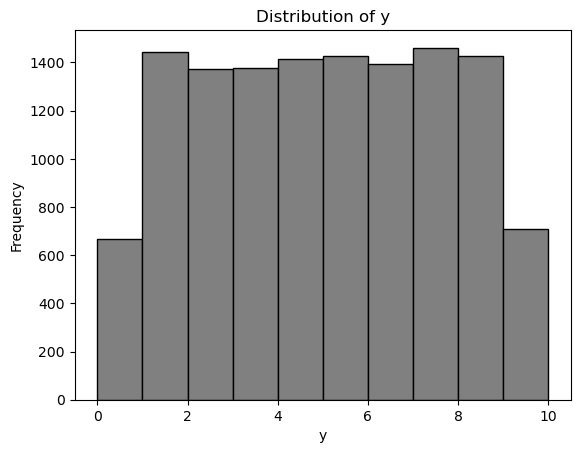

In [57]:
# Visualization of y
import matplotlib.pyplot as plt
plt.hist(y_train, bins=range(0, max(y_train)+2), color='gray', edgecolor='black', align='mid')
plt.title("Distribution of y")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.show() # no need to log transform